In [1]:
# IMPORTING REQUIRED PACKAGES
import os
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # INITIALIZE LAYERS HERE
        self.first_layer = nn.Sequential(
            nn.Conv2d(3, 256, 6),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2)
        )

        self.second_layer = nn.Sequential(
            nn.Conv2d(256, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )

        self.third_layer = nn.Sequential(
            nn.Conv2d(384, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )

        self.fourth_layer = nn.Sequential(
            nn.Conv2d(384, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU()
        )

        self.classification = nn.Linear(4096, 10)

        # default initialization is used

        # if init_weights:
        #     self._initialize_weights()

    def forward(self, x):
        # PASS IMAGE X THROUGH EACH LAYER DEFINED ABOVE
        out = self.first_layer(x)
        out = self.second_layer(out)
        out = self.third_layer(out)
        out = self.fourth_layer(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.classification(out)
        return out

    def _initialize_weights(self):
        #INITIALIZE WEIGHTS
        # default initialization is used
        pass


In [3]:
def train():
    # DEFINE VARIABLE
    BATCH_SIZE = 128  # YOU MAY CHANGE THIS VALUE
    EPOCH_NUM = 25  # YOU MAY CHANGE THIS VALUE
    LR = 0.001  # YOU MAY CHANGE THIS VALUE
    MODEL_SAVE_PATH = './Models'

    if not os.path.exists(MODEL_SAVE_PATH):
        os.mkdir(MODEL_SAVE_PATH)

    # DEFINING TRANSFORM TO APPLY TO THE IMAGES
    # YOU MAY ADD OTHER TRANSFORMS FOR DATA AUGMENTATION
    transform = transforms.Compose(
        [transforms.Resize(32),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    ########################################################################
    # 1. LOAD AND NORMALIZE CIFAR10 DATASET
    ########################################################################

    # FILL IN: Get train and test dataset from torchvision and create respective dataloader
    trainset = CIFAR10('./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    testset = CIFAR10('./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

    ########################################################################
    # 2. DEFINE YOUR CONVOLUTIONAL NEURAL NETWORK AND IMPORT IT
    ########################################################################

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ConvNet().to(device)  # MAKE SURE TO DEFINE ConvNet IN A CELL ABOVE THE STARTER CODE OF WHICH IS IN cnn_model.py
    # You can pass arguments to ConvNet if you want instead of hard coding them.


    ########################################################################
    # 3. DEFINE A LOSS FUNCTION AND OPTIMIZER
    ########################################################################

    # FILL IN : the criteria for ce loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

    ########################################################################
    # 4. TRAIN THE NETWORK
    ########################################################################

    test_accuracy = []
    train_accuracy = []
    train_loss = []
    test_min_acc = 0
    net.train()

    for epoch in range(EPOCH_NUM):  # loop over the dataset multiple times

        running_loss = 0.0
        total = 0
        correct = 0

        for i, data in enumerate(trainloader, 0):
            net.train()
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            # FILL IN: Obtain accuracy for the given batch of TRAINING data using
            # the formula acc = 100.0 * correct / total where
            # total is the total number of images processed so far
            # correct is the correctly classified images so far

            total += inputs.size(0)
            correct += torch.count_nonzero((predicted == labels).long()).item()

            train_loss.append(loss.item())
            train_accuracy.append(100.0 * correct / total)

            if (i + 1) % 20 == 0:
                print('Train: [%d, %5d] loss: %.3f acc: %.3f' % (epoch + 1, i + 1,
                                                                 running_loss / 20,
                                                                 100.0 * correct / total))
                running_loss = 0.0

        # TEST LEARNT MODEL ON ENTIRE TESTSET
        # FILL IN: to get test accuracy on the entire testset and append
        # it to the list test_accuracy

        correct = 0
        total = 0
        net.eval()
        with torch.no_grad():
            for data in testloader:
                # YOUR CODE HERE
                test_inputs, test_labels = data
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                test_preds = net(test_inputs)
                test_preds = torch.argmax(test_preds, dim=1)
                total += test_inputs.size(0)
                correct += torch.count_nonzero((test_preds == test_labels).long()).item()
            test_accuracy.append(100.0 * correct / total)
        net.train()

        test_ep_acc = test_accuracy[-1]
        print('Test Accuracy: %.3f %%' % test_ep_acc)

        # SAVE BEST MODEL
        if test_min_acc < test_ep_acc:
            test_min_acc = test_ep_acc
            torch.save(net, MODEL_SAVE_PATH + '/my_best_model.pth')

    # PLOT THE TRAINING LOSS VS EPOCH GRAPH
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(len(train_loss))), train_loss)
    plt.title('training loss vs. iteration')
    plt.xlabel('iteration')
    plt.ylabel('training loss')
    plt.savefig('training_loss_vs_iteration_plot.jpg', dpi=300)
    plt.show()

    # PLOT THE TESTING ACCURACY VS EPOCH GRAPH
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(len(test_accuracy))), test_accuracy)
    plt.title('test accuracy vs. epoch')
    plt.xlabel('epoch')
    plt.ylabel('test_accuracy')
    plt.savefig('test_accuracy_vs_epoch_plot.jpg', dpi=300)
    plt.show()

    # PRINT THE FINAL TESTING ACCURACY OF YOUR BEST MODEL
    print('the best testing accuracy: {}'.format(max(test_accuracy)))

    print('Finished Training')

Files already downloaded and verified
Files already downloaded and verified
Train: [1,    20] loss: 2.208 acc: 19.102
Train: [1,    40] loss: 1.840 acc: 25.820
Train: [1,    60] loss: 1.726 acc: 29.818
Train: [1,    80] loss: 1.575 acc: 33.330
Train: [1,   100] loss: 1.495 acc: 35.938
Train: [1,   120] loss: 1.433 acc: 38.066
Train: [1,   140] loss: 1.366 acc: 39.749
Train: [1,   160] loss: 1.395 acc: 40.894
Train: [1,   180] loss: 1.379 acc: 41.984
Train: [1,   200] loss: 1.294 acc: 43.172
Train: [1,   220] loss: 1.228 acc: 44.261
Train: [1,   240] loss: 1.250 acc: 45.228
Train: [1,   260] loss: 1.255 acc: 45.977
Train: [1,   280] loss: 1.185 acc: 46.830
Train: [1,   300] loss: 1.226 acc: 47.453
Train: [1,   320] loss: 1.211 acc: 48.081
Train: [1,   340] loss: 1.195 acc: 48.642
Train: [1,   360] loss: 1.151 acc: 49.188
Train: [1,   380] loss: 1.113 acc: 49.741
Test Accuracy: 61.210 %
Train: [2,    20] loss: 1.051 acc: 61.562
Train: [2,    40] loss: 1.057 acc: 61.895
Train: [2,    60] 

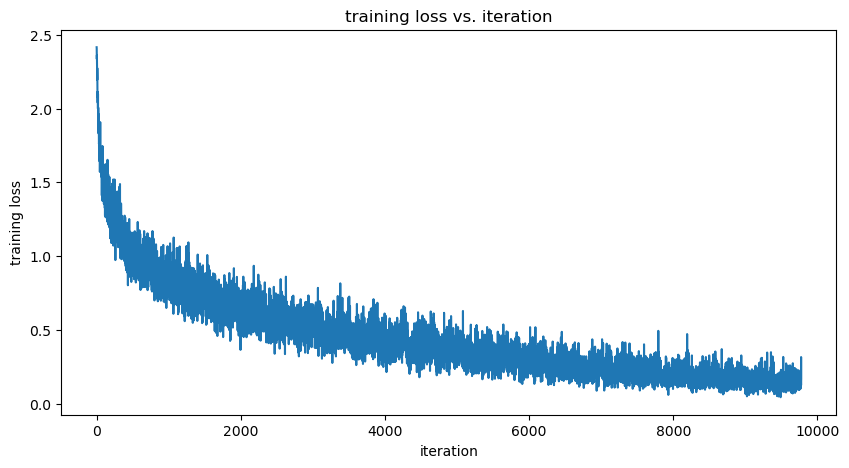

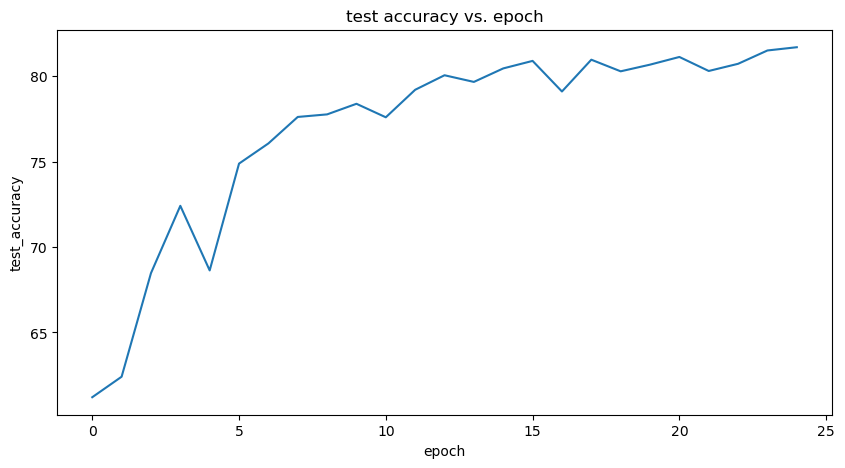

the best testing accuracy: 81.69
Finished Training


In [4]:
train()

Based on the both training accuracy and test accuracy the model is about the over fit but not that much. If we select a larger epoch size then probably it will over fit. Also, with a small learning rate and more epoch number the training can be more stable. However, the resulting accuracy is reasonable fine.